In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
'''This script uses the synthetic data from the Groves' MATLAB implementation
of the inertial navigation book (https://github.com/ymjdz/MATLAB-Codes) for
loosely-coupled IMU/GNSS integration'''

"This script uses the synthetic data from the Groves' MATLAB implementation\nof the inertial navigation book (https://github.com/ymjdz/MATLAB-Codes) for\nloosely-coupled IMU/GNSS integration"

In [149]:
def Nav_equations_ECEF(dt, old_r_eb_e, old_C_b_e, old_v_eb_e, f_ib_b, omega_ib_b):
    
    '''
    This function integrates IMU data to obtain the predicted orientation (as CTM), velocity, 
    and position in ECEF frame.
    
    Inputs:
        dt            time interval between epochs (s)
        old_r_eb_e    previous Cartesian position of body frame w.r.t. ECEF
                      frame, resolved along ECEF-frame axes (m)
        old_C_b_e     previous body-to-ECEF-frame coordinate transformation matrix
        old_v_eb_e    previous velocity of body frame w.r.t. ECEF frame, resolved
                      along ECEF-frame axes (m/s)
        f_ib_b        specific force of body frame w.r.t. ECEF frame, resolved
                      along body-frame axes, averaged over time interval (m/s^2)
        omega_ib_b    angular rate of body frame w.r.t. ECEF frame, resolved
                      about body-frame axes, averaged over time interval (rad/s)
    Outputs:
        r_eb_e        Cartesian position of body frame w.r.t. ECEF frame, resolved
                      along ECEF-frame axes (m)
        v_eb_e        velocity of body frame w.r.t. ECEF frame, resolved along
                      ECEF-frame axes (m/s)
        C_b_e         body-to-ECEF-frame coordinate transformation matrix

    '''
    
    # # # Update esimated navigation solution in ECEF (equivalent to the function Nav_equations_ECEF in Groves' MATLAB codes)
    # Parameters
    omega_ie = 7.292115e-5  # Earth rotation rate [rad/s]
    
    # # Attitude update
    # Determine the Earth rotation over the update interval
    alpha_ie = omega_ie * dt  #  [rad]
    # Define the matrix converting bewteen inertial to ECEF frame (Equation 2.145)
    C_i_e = np.array([[np.cos(alpha_ie), np.sin(alpha_ie), 0],
                    [-np.sin(alpha_ie), np.cos(alpha_ie), 0],
                     [0, 0, 1]])        
    
    # Calculate attitude increment, magnitude, and skew-symmetric matrix
    alpha_ib_b = omega_ib_b * dt
    mag_alpha = np.linalg.norm(alpha_ib_b)
    Alpha_ib_b = SkewSymmetric(alpha_ib_b)

    # Obtain coordinate transformation matrix from the new attitude w.r.t an
    # inertial frame to the old using Rodrigues' formula (Eq. 5.73)
    if mag_alpha > 1e-8:
        C_new_old = (np.eye(3) + 
                     np.sin(mag_alpha) / mag_alpha * Alpha_ib_b +
                     (1 - np.cos(mag_alpha)) / mag_alpha**2 * Alpha_ib_b @ Alpha_ib_b)
    else:
        C_new_old = np.eye(3) + Alpha_ib_b

    # Update attitude using Eq. 5.75
    new_C_b_e = C_i_e @ old_C_b_e @ C_new_old

    
    # # Specific force frame transformation
    # Calculate the average body-to-ECEF coordinate transformation matrix
    # over the update interval (using Eqs.5.84 and 5.85)
    if mag_alpha > 1e-8:                
        # Contribution total rotation due to rotation of the body
        body_rotation_term = old_C_b_e @ (np.eye(3) + 
                                              (1 - np.cos(mag_alpha)) / mag_alpha**2 * Alpha_ib_b +
                                              (1 - np.sin(mag_alpha) / mag_alpha) / mag_alpha**2 * Alpha_ib_b @ Alpha_ib_b)

        # Contribution total rotation due to rotation of the Earth
        earth_rotation_term =  0.5 * SkewSymmetric([0, 0, alpha_ie]) @ old_C_b_e # Rotatio of the earth

        ave_C_b_e = body_rotation_term - earth_rotation_term
    else:
        # Contribution total rotation due to rotation of the Earth
        earth_rotation_term =  0.5 * SkewSymmetric([0, 0, alpha_ie]) @ old_C_b_e # Rotatio of the earth
        
        ave_C_b_e = old_C_b_e - earth_rotation_term

    # Transform specific force to ECEF-frame resolving axes using (Eq. 5.85)
    f_ib_e = ave_C_b_e @ f_ib_b;


    # # Update velocity (Eq. 5.36)
    new_v_eb_e = old_v_eb_e + dt * (f_ib_e + Gravity_ECEF(old_r_eb_e) -
                                         2 * SkewSymmetric([0, 0, omega_ie]) @ old_v_eb_e)


    # # Update cartesian position (Eq. 5.36)
    new_r_eb_e = old_r_eb_e + (new_v_eb_e + old_v_eb_e) * 0.5 * dt

    return new_r_eb_e, new_v_eb_e, new_C_b_e

In [193]:
# # Functions

def GetConstants():

    '''This function provides WGS84 ellipsoidal parameters and unit conversions for navigation'''

    return {
        "D2R": math.pi / 180,         # From degrees to radian
        "R2D": 180 / math.pi,         # From radian to degrees
        "omega_ie": 7.2921151467E-5,  # Earth rotation rate [rad/s]
        "R0": 6378137,                # Earth’s equatorial radius (Earth's semi-major axis) [m]
        "Rb": 6356752.3142451793,     # Earth's semi-minor axis [m]
        "mu": 3.986004418e14,         # Earth's Gravitational Constant [m^3/s^2]
        "J2": 1.082627e-3,            # Earth's second Gravitational Constant [m^3/s^2]
        "e1_sqr": 0.0066943799901413156,  # First Eccentricity Squared
        "e2_sqr": 0.0067394967422764341,   # Second Eccentricity Squared
        "micro_g_to_meters_per_second_squared": 9.80665E-6, # Convert micro-g to m/s^2
    }


def ReadData():

    '''
    This function reads the synthetic position and IMU data
    
    Outputs:
        * output_data - contains the states with noise and the synthetic 
        specific force and angular rate data
        * input_truth_data - contains the ground truth states data
    
    '''
    # # Define paths
    path_root = r'C:\Postdoc\Analysis\Preliminaries\Data\Synthetic_INS_Groves_MATLAB'
    path_simulated = os.path.join(path_root, 'INS_GNSS_Demo_Profile_2.csv')  # This is data with noise, including specific force, angular rate and GNSS data
    path_truth = os.path.join(path_root, 'Profile_2_truth.csv')  # This is the ground truth data

    # Read data
    noisy_state_IMU_data = pd.read_csv(path_simulated, skiprows=[1])
    true_state_data = pd.read_csv(path_truth, skiprows=[1])

    return noisy_state_IMU_data, true_state_data


def euler2dcm(euler):

    '''
    This function constructs the coordinate transformation matrix
    (CTM, also known as DCM (direction cosine matrix)) from body to navigation frame (C_bn)
    
    Inputs:
        euler       Euler angles - phi, theta and psi (roll, pitch, yaw) in radian
           
       '''

    dcm = np.zeros((3, 3))

    phi = euler[0]    # roll
    theta = euler[1]  # pitch
    psi = euler[2]    # yaw (heading)

    cphi = np.cos(phi)
    sphi = np.sin(phi)
    ctheta = np.cos(theta)
    stheta = np.sin(theta)
    cpsi = np.cos(psi)
    spsi = np.sin(psi)

    dcm[0, 0] = ctheta * cpsi
    dcm[0, 1] = -cphi * spsi + sphi * stheta * cpsi
    dcm[0, 2] = sphi * spsi + cphi * stheta * cpsi

    dcm[1, 0] = ctheta * spsi
    dcm[1, 1] = cphi * cpsi + sphi * stheta * spsi
    dcm[1, 2] = -sphi * cpsi + cphi * stheta * spsi

    dcm[2, 0] = -stheta
    dcm[2, 1] = sphi * ctheta
    dcm[2, 2] = cphi * ctheta

    return dcm


def SkewSymmetric(a):

    '''
    This function converts a vector x into a skew symmetric matrix
    which multiplication by a vector y is equivalent to performing
    a cross product between vectors x and y

     Inputs:
           a       3-element vector
     Outputs:
           A       3x3 matrix
    '''

    A = np.array([
        [0, -a[2], a[1]],
        [a[2], 0, -a[0]],
        [-a[1], a[0], 0]
    ])

    return A


def RadiiOfCurvature(L_b):

    '''
    This function calculates the transverse and the meridian radii of curavture 
    given the a specific lattitude

    Inputs:
           L_b    geodetic latitude [rad]
     Outputs:
           R_E    transverse radius of curvature [m]
           R_M    meridian radius of curvature [m]
    
    
    '''

    # Parameters
    R_0 = 6378137 # WGS84 Equatorial radius [m]
    e = 0.0818191908425; # WGS84 eccentricity

    # Preparataions
    temp = 1 - (e * np.sin(L_b))**2

    # Calculate transverse radius of curvature (using Eq. 2.105)
    R_E = R_0 / np.sqrt(temp);
    
    # Calculate meridian radius of curvature (using Eq. 2.105)    
    R_N = R_0 * (1 - e**2) / temp**1.5;    

    return  R_E, R_N

def Gravity_NED(L_b, h_b):

    '''
    This function calculates acceleration due to gravity resolved about 
    north, east, and down

    Inputs:
           lat    geodetic latitude [rad]
           h_b    height [m]
     Outputs:
           g       Acceleration due to gravity [m/s^2]
    '''

    # Parameters
    R_0 = 6378137  # %WGS84 Equatorial radius in meters
    R_P = 6356752.31425  # WGS84 Polar radius in meters
    e = 0.0818191908425  # WGS84 eccentricity
    f = 1 / 298.257223563  # WGS84 flattening
    mu = 3.986004418E14  # WGS84 Earth gravitational constant (m^3 s^-2)
    omega_ie = 7.292115E-5  # Earth rotation rate (rad/s)
    
    # Calculate surface gravity using the Somigliana model (Eq. 2.134)
    sinsqL = np.sin(L_b)**2
    g_0 = 9.7803253359 * (1 + 0.001931853 * sinsqL) / np.sqrt(1 - e**2 * sinsqL)

    # Preallocate g
    g = np.zeros([3,1])

    
    # Calculate north gravity using (2.140)
    g_N = -8.08E-9 * h_b * np.sin(2 * L_b)
    
    # East gravity is zero
    g_E = 0
    
    # Calculate down gravity using (2.139)
    g_D = g_0 * (1 - 
                  (2 / R_0) * (1 + f * (1 - 2 * sinsqL) + (omega_ie**2 * R_0**2 * R_P / mu)) * h_b + 
                  (3 * h_b**2 / R_0**2))
                    
    return np.array([g_N, g_E, g_D])


def CTM_to_Euler(C):

    """
    This function onverts a coordinate transformation matrix to the
    corresponding set of Euler angles

    Inputs:
        C       coordinate transformation matrix describing transformation from
                beta to alpha
 
  Outputs:
        eul     Euler angles describing rotation from beta to alpha in the 
                order roll, pitch, yaw(rad)
    """

    # Preallocate output
    eul = np.zeros(3)
    
    # Calculate Euler angles using (2.23)
    eul[0] = np.arctan2(C[1,2],C[2,2]);  # roll  [rad]
    eul[1] = - np.arcsin(C[0,2]);        # pitch [rad]
    eul[2] = np.arctan2(C[0,1],C[0,0]);  # yaw   [rad]
    
    return eul

    
def NED_to_ECEF(L_b, lambda_b, h_b, v_eb_n, C_b_n):

    '''
    Converts curvilinear to Cartesian position, velocity
    resolving axes from NED to ECEF and attitude from NED- to ECEF-referenced

    Inputs:
       L_b           latitude (rad)
       lambda_b      longitude (rad)
       h_b           height (m)
       v_eb_n        velocity of body frame w.r.t. ECEF frame, resolved along
                     north, east, and down (m/s)
       C_b_n         body-to-NED coordinate transformation matrix
         
  Outputs:
       r_eb_e        Cartesian position of body frame w.r.t. ECEF frame, resolved
                     along ECEF-frame axes (m)
       v_eb_e        velocity of body frame w.r.t. ECEF frame, resolved along
                     ECEF-frame axes (m/s)
       C_b_e         body-to-ECEF-frame coordinate transformation matrix
    '''

    R_0 = 6378137  # WGS84 Equatorial radius in meters
    e = 0.0818191908425  # WGS84 eccentricity

    # Calculate transverse radius of curvature (Eq. 2105)
    R_E = R_0/np.sqrt(1 - (e * np.sin(L_b))**2)

    # Convert position using (2.112)
    cos_lat = np.cos(L_b);
    sin_lat = np.sin(L_b);
    cos_long = np.cos(lambda_b);
    sin_long = np.sin(lambda_b);
    # r_eb_e = np.array([(R_E + h_b) * cos_lat * cos_long,     # This is fromm the MATLAB code but I am not sure it is required here
    #                   (R_E + h_b) * cos_lat * sin_long,
    #                   ((1 - e**2) * R_E + h_b) * sin_lat])
      
    # Calculate ECEF to NED coordinate transformation matrix using (2.150 (2.99))
    C_e_n = np.array([[-sin_lat * cos_long, -sin_lat * sin_long,  cos_lat], 
                      [-sin_long,            cos_long,        0], 
                      [-cos_lat * cos_long, -cos_lat * sin_long, -sin_lat]])
     
    ## Transform velocity using (2.73)  # This is fromm the MATLAB code but I am not sure it is required here
    #v_eb_e = C_e_.T @ v_eb_n;
    
    # Transform attitude using (2.15)
    C_b_e = C_e_n.T @ C_b_n;

    return C_b_e  # r_eb_e, v_eb_e, 


def Gravity_ECEF(r_eb_e):

    '''
    This function alculates  acceleration due to gravity resolved about 
    ECEF-frame

    Inputs:
       old_est_r_eb_e   Cartesian position of body frame w.r.t. ECEF frame,
                        resolved about ECEF frame axes [m]

    Outputs:
       g                Acceleration due to gravity [m/s^2]
    
    '''

    # Parameters
    R_0 = 6378137 # WGS84 Equatorial radius in meters [m]
    mu = 3.986004418E14  # WGS84 Earth gravitational constant [m^3 s^-2]
    J_2 = 1.082627E-3  # WGS84 Earth's second gravitational constant
    omega_ie = 7.292115E-5  # Earth rotation rate [rad/s]

    # Ensure input is a flat 1D array for easier indexing
    r_eb_e = np.asarray(r_eb_e).flatten()
    
    # Calculate distance from center of the Earth
    mag_r = np.linalg.norm(r_eb_e);
    
    # If the input position is 0,0,0, produce a dummy output
    if mag_r==0:
        g = np.array([0,0,0])
         
    else:
        # Calculate gravitational acceleration (using Eq. 2.142)
        z_scale = 5 * (r_eb_e[2] / mag_r)**2;
        
        gamma = -mu / mag_r**3 * (r_eb_e + 1.5 * J_2 * (R_0 / mag_r)**2 * 
            np.array([(1 - z_scale) * r_eb_e[0], 
                      (1 - z_scale) * r_eb_e[1], 
                      (3 - z_scale) * r_eb_e[2]]))
    
        # Add centripetal acceleration using (Eq. 2.133)
        g = np.zeros(3)
        
        g[0:2] = gamma[0:2] + omega_ie**2 * r_eb_e[0:2]
        g[2] = gamma[2];


    return g


def ECEF_to_NED(r_eb_e,v_eb_e,C_b_e):

    '''
    This function converts Cartesian to curvilinear position, velocity
    resolving axes from ECEF to NED and attitude from ECEF- to NED-referenced

    Inputs:
        r_eb_e       Cartesian position of body frame w.r.t. ECEF frame, resolved
                     along ECEF-frame axes (m)
       v_eb_e        velocity of body frame w.r.t. ECEF frame, resolved along
                     ECEF-frame axes (m/s)
       C_b_e         body-to-ECEF-frame coordinate transformation matrix

    Outputs:
       L_b           latitude (rad)
       lambda_b      longitude (rad)
       h_b           height (m)
       v_eb_n        velocity of body frame w.r.t. ECEF frame, resolved along
                     north, east, and down (m/s)
       C_b_n         body-to-NED coordinate transformation matrix

    '''
    # Parameters
    R_0 = 6378137 # WGS84 equitorial redius [m]
    e = 0.0818191908425    # EGS84 Earth eccentricity

    # # Get curvilinear coordinates
    # # (Convert position using Borkowski colsed-form exact solution)
    # longitude - From equation 2.113 (needs to use atan2 to account for the coordinate angle sign)
    lambda_b = np.atan2(r_eb_e[1],r_eb_e[0])

    # From (C.29) and (C.30)
    k1 = np.sqrt(1 - e**2) * np.abs(r_eb_e[2]);
    k2 = e**2 * R_0;
    beta = np.sqrt(r_eb_e[0]**2 + r_eb_e[1]**2)
    E = (k1 - k2) / beta
    F = (k1 + k2) / beta
    
    # From (C.31)
    P = 4/3 * (E*F + 1)
    
    # From (C.32)
    Q = 2 * (E**2 - F**2)
    
    # From (C.33)
    D = P**3 + Q**2
    
    # From (C.34)
    V = np.cbrt(np.sqrt(D) - Q) - np.cbrt(np.sqrt(D) + Q)
    
    # From (C.35)
    G = 0.5 * (np.sqrt(E**2 + V) + E)
    
    # From (C.36)
    T = np.sqrt(G**2 + (F - V * G) / (2 * G - E)) - G
    
    # From (C.37)
    L_b = np.sign(r_eb_e[2]) * np.atan((1 - T**2) / (2 * T * np.sqrt(1 - e**2)))
    
    # From (C.38)
    h_b = (beta - R_0 * T) * np.cos(L_b) + (r_eb_e[2] - np.sign(r_eb_e[2]) * R_0 * np.sqrt(1 - e**2)) * np.sin (L_b)


    # Get ECEF to NED coordinate transformation matrix (Eq. 2.150)
    sin_lat = np.sin(L_b)
    cos_lat = np.cos(L_b)
    sin_long = np.sin(lambda_b)
    cos_long = np.cos(lambda_b)

    C_e_n = np.array([[-sin_lat * cos_long, -sin_lat * sin_long,  cos_lat], 
                     [-sin_long,            cos_long,        0], 
                     [-cos_lat * cos_long, -cos_lat * sin_long, -sin_lat]])

    # Transform velocity using (2.73)
    v_eb_n = C_e_n @ v_eb_e
    
    # Transform attitude using (2.15)
    C_b_n = C_e_n @ C_b_e

    return L_b, lambda_b, h_b, v_eb_n, C_b_n


def Initialize_LC_P_matrix(LC_KF_config):

    '''
    This function intializes the loosely coupled INS/GNSS KF
    error covariance matrix

    Inputs:
        TC_KF_config
        .init_att_unc    Initial attitude uncertainty per axis [rad]
        .init_vel_unc    Initial velocity uncertainty per axis [m/s]
        .init_pos_unc    Initial position uncertainty per axis [m]
        .init_b_a_unc    Initial accel. bias uncertainty [m/s^2]
        .init_b_g_unc    Initial gyro. bias uncertainty [rad/s]

   Outputs:
        P_matrix         state estimation error covariance matrix
    '''

    # Initialize error covariance matrix
    P_matrix =  np.zeros((15,15))
    
    P_matrix[0:3,0:3] = np.eye(3) * LC_KF_config['init_att_unc']**2
    P_matrix[3:6,3:6] = np.eye(3) * LC_KF_config['init_vel_unc']**2
    P_matrix[6:9,6:9] = np.eye(3) * LC_KF_config['init_pos_unc']**2
    P_matrix[9:12,9:12] = np.eye(3) * LC_KF_config['init_b_a_unc']**2
    P_matrix[12:15,12:15] = np.eye(3) * LC_KF_config['init_b_g_unc']**2
    
    return P_matrix
    

    

In [206]:
# Get Constants
Const = GetConstants()

# Read data
imu, truth = ReadData()

# # Define GNSS configuration
GNSS_config = {
    'epoch_interval': 0.5, # Interval between GNSS epochs [s]
}

# # Define loosely coupled Kalman filter configuration
LC_KF_config = {
    'gyro_noise_PSD': (0.02 * Const['D2R'] / 60)**2,    # gyro noise PSD [rad^2/s]
    'accel_noise_PSD': 200 * Const['micro_g_to_meters_per_second_squared']**2,  #  accelerometer noise PSD [m^2/s^3]
    'accel_bias_PSD': 1.0E-7,          #  accelerometer bias random walk PSD [m^2/s^5]
    'gyro_bias_PSD': 2.0E-12,          #  gyro bias random walk PSD [rad^2/s^3]
    'pos_meas_SD': 2.5,                #  position measured noise SD per axis [m]
    'vel_meas_SD': 0.1,                #  velocity measured noise SD per axis [m/s]
    'init_att_unc': 1 * Const['D2R'],  # Initial attitude uncertainty per axis [rad]
    'init_vel_unc': 0.1,               # Initial velocity uncertainty per axis [m/s]
    'init_pos_unc': 10,                # Initial position uncertainty per axis [m]
    'init_b_a_unc': 1000 * Const['micro_g_to_meters_per_second_squared'],  # Initial accel. bias uncertainty [m/s^2]
    'init_b_g_unc': 10 * Const['D2R'] / 3600,    # Initial gyro. bias uncertainty [rad/s]
}

# Get number of epochs
no_epochs = imu.shape[0]

# Perform script initialization
# Initialize estimated navigation solution
old_time = imu['time'][0]  # [sec]
old_est_L_b = imu['lat'][0] * Const['D2R']  # [rad]
old_est_lambda_b = imu['lon'][0] * Const['D2R']  # [rad]
old_est_h_b = imu['height'][0]  # [m]
old_est_v_eb_n = imu.iloc[0, 4:7].to_numpy()  # [m/s]
old_est_eul_nb = imu.iloc[0, 7:10].to_numpy() * Const['D2R']  # [rad]
old_est_C_b_n = euler2dcm(old_est_eul_nb)

old_est_C_b_e = NED_to_ECEF(old_est_L_b, old_est_lambda_b,
                            old_est_h_b, old_est_v_eb_n, old_est_C_b_n)


# Get initial position from GNSS (after noise addition)
old_est_r_eb_e = imu.iloc[0, 16:19].to_numpy()  # [m] - from GNSS
old_est_v_eb_e = imu.iloc[0, 19:22].to_numpy()  # [m/s] - from GNSS

# Initialize Kalman filter P matrix and IMU bias states
P_matrix = Initialize_LC_P_matrix(LC_KF_config)
old_est_IMU_bias = np.zeros(6)

# Initialize GNSS model timing
time_last_GNSS = old_time
GNSS_epoch = 1

# # Save navigation solution in a dedicated array
# Preallocation
nav_solution = np.zeros((no_epochs, 10))

# nav_solution is the dataframe where states obtained by integrating IMU data will be saved
nav_solution[0, :] = imu.iloc[0, :10].to_numpy()

# Initialize GNSS model timing
time_last_GNSS = old_time
GNSS_epoch = 1

# ---------------------
# Main loop - Start IMU integration with occasional updates using the GNSS data
# ---------------------
for epoch in range(1, no_epochs):   # for epoch in range(1, 200):

    # Unpack current measured data
    new_time = imu['time'][epoch]  # time stamp [sec]
    f_ib_b = imu.iloc[epoch, 10:13].to_numpy()   # Specific force [m/s^2]
    omega_ib_b = imu.iloc[epoch, 13:16].to_numpy()  # angular rate [rad/s]

    # Get the time interval between the previous and current measurement
    dt = new_time - old_time

    # Correct IMU errors
    f_ib_b = f_ib_b - est_IMU_bias[0:3]
    omega_ib_b = omega_ib_b - est_IMU_bias[3:6]

    # # # Update esimated navigation solution in ECEF (equivalent to the function Nav_equations_ECEF in Groves' MATLAB codes)
    (new_est_r_eb_e, new_est_v_eb_e, new_est_C_b_e) = Nav_equations_ECEF(
        dt, old_est_r_eb_e, old_est_C_b_e, old_est_v_eb_e, f_ib_b, omega_ib_b)

    # Determine whether to update GNSS simulation and run Kalman filter
    if (new_time - time_last_GNSS) >= GNSS_config['epoch_interval']:
        GNSS_epoch = GNSS_epoch + 1
        dt_s = new_time - time_last_GNSS  # KF time interval
        time_last_GNSS = new_time

        # GNSS measurements
        GNSS_r_eb_e = imu.iloc[epoch, 16:19].to_numpy()  # [m] - from GNSS
        GNSS_v_eb_e = imu.iloc[epoch, 19:22].to_numpy()  # [m/s] - from GNSS

        # ------------------------------------------------------------------------
        # # # loosely coupled INS/GNSS error-state Kalman filter
        # (according to the function LC_KF_Epoch from Groves' MATLAB code)
        # ------------------------------------------------------------------------
    
        '''
        This function implements one cycle of the loosely coupled INS/GNSS
        Kalman filter plus closed-loop correction of all inertial states.
    
        Inputs:
            GNSS_r_eb_e             GNSS estimated ECEF user position [m]
            GNSS_v_eb_e             GNSS estimated ECEF user velocity [m/s]
            dt_s                    propagarion interval [s]
            old_est_C_b_e           prior estimated body to ECEF coordinate 
                                    transforamation matrix
            old_est_v_eb_e          prior estimated ECEF user velocity [m/s]
            old_est_r_eb_e          prior estimated ECEF user position [m]
            old_est_IMU_bias        priot estimated IMU bias (body axes)
            P_matrix_old            previous Kalman filter error covariance matrix
            f_ib_b                  measured specific force [m/s^2]
            old_est_L_b             previous latitude solution [rad]
            LC_KF_config
                gyro_noise_PSD      gyro noise PSD [rad^2/s]
                accel_noise_PSD     accelerometer noise PSD [m^2/s^3]
                accel_bias_PSD       accelerometer bias random walk PSD [m^2/s^5]
                gyro_bias_PSD       gyro bias random walk PSD [rad^2/s^3]
                pos_meas_SD         position measured noise SD per axis [m]
                vel_meas_SD         velocity measured noise SD per axis [m/s]
                                        
           
        Outputs:
            new_est_C_b_e           updated estimated body to ECEF coordinate
                                    transformation matrix
            new_est_v_eb_e          updated estimated eceF user velocity [m/s]
            new_est_r_eb_e          updated estimated eceF user position [m]
            new_est_IMU_bias        updated estimated IMU biases 
                rows 1-3            estimated accelerometer biases [m/s^2]
                rows 4-6            estimated gyro biases [rad/s]
            P_matrix_new            updated Kalman filter error covariance matriz
        '''

        # # # # ** Temporary
        P_matrix_old = P_matrix
        
        # # # Preparations
        # Constants
        omega_ie = 7.292115E-5  # Earth rotation rate in [rad/s]
        R_0 = 6378137  # WGS84 Equatorial radius in [m]
        e = 0.0818191908425  # WGS84 eccentricity

        # Skew symmetric matrix for Earth rate
        Omega_ie = SkewSymmetric([0, 0, omega_ie])

        # # Measured for calculating F_23 from Eq. 14.50/14.49
        # Calculate geocentric radius (Eq. 2.137)
        R_E = R_0 / np.sqrt(1 - (e**2 * np.sin(old_est_L_b)**2))
        geocentric_radius = R_E * np.sqrt(np.cos(old_est_L_b)**2 + (1-e**2)**2 * np.sin(old_est_L_b)**2)
        # Calculate the magnitude of the position vector in ECEF
        mag_r = np.linalg.norm(old_est_r_eb_e)
        # Calculate the gravity vector at the current position in ECEF
        g_ecef = Gravity_ECEF(old_est_r_eb_e)
        
        # # # System propagation phase
        # # 1. Determine the transition matrix (Phi - the first-order discrete time system propagation matrix - Eq. 14.50)
        Phi_matrix = np.eye(15)
        
        # Orientaion error
        Phi_matrix[0:3,0:3] = Phi_matrix[0:3,0:3] - Omega_ie * dt_s
        Phi_matrix[0:3,12:15] = old_est_C_b_e * dt_s

        # Velocity error
        Phi_matrix[3:6,0:3] = -dt_s * SkewSymmetric(old_est_C_b_e @ f_ib_b) # dt * F_21 from Eq. 14.50/14.49
        Phi_matrix[3:6,3:6] = Phi_matrix[3:6,3:6] - 2 * Omega_ie * dt_s
        Phi_matrix[3:6,6:9] = (-dt_s * 2 * np.outer(g_ecef, old_est_r_eb_e) / 
                               (geocentric_radius * mag_r))  # dt * F_23 from Eq. 14.50/14.49
        Phi_matrix[3:6,9:12] = old_est_C_b_e * dt_s

        # Position error
        Phi_matrix[6:9,3:6] = np.eye(3) * dt_s

        # # 2. Determine approximate system noise covariance matrix (using Eq. 14.82)
        Q_prime_matrix = np.zeros((15,15))
        
        Q_prime_matrix[0:3, 0:3] = np.eye(3) * LC_KF_config['gyro_noise_PSD'] * dt_s
        Q_prime_matrix[3:6, 3:6] = np.eye(3) * LC_KF_config['accel_noise_PSD'] * dt_s
        Q_prime_matrix[9:12, 9:12] = np.eye(3) * LC_KF_config['accel_bias_PSD'] * dt_s
        Q_prime_matrix[12:15, 12:15] = np.eye(3) * LC_KF_config['gyro_bias_PSD'] * dt_s

        # # 3. Propagate state estimates (using Eq. 3.14) noting that all states are zero 
        # due to closed-loop correction.
        x_est_propagated = np.zeros(15)
        
        # # 4. Propagate state estimation error covariance matrix (using Eq. 3.46) - this is P_k|k-1
        P_matrix_propagated = (Phi_matrix @ (P_matrix_old + 0.5 * Q_prime_matrix) @ Phi_matrix.T +   # need to define P_matrix_old - add LC_FK_config keys -> defeine a matrix that does it
                               0.5 * Q_prime_matrix)  
            
        
        # # # MEASUREMENT UPDATE PHASE 
        # 5. Set-up measurement matrix (using Eq. 14.115)
        H_matrix = np.zeros((6,15))
        H_matrix[0:3,6:9] = -np.eye(3);
        H_matrix[3:6,3:6] = -np.eye(3);

        # 6. Set-up measurement noise covariance matrix assuming all components of
        # GNSS position and velocity are independent and have equal variance.
        R_matrix = np.zeros((6,6))
        R_matrix[0:3, 0:3] = np.eye(3) * LC_KF_config['pos_meas_SD']**2
        R_matrix[0:3, 3:6] = np.zeros((3,3))
        R_matrix[3:6, 0:3] = np.zeros((3,3))
        R_matrix[3:6, 3:6] = np.eye(3) * LC_KF_config['vel_meas_SD']**2

        # 7. Calculate the innovation covariance
        S_matrix = H_matrix @ P_matrix_propagated @ H_matrix.T + R_matrix

        # 8. Calculate Kalman gain (using Eq. 3.21)
        K_matrix = P_matrix_propagated @ H_matrix.T @ np.linalg.inv(S_matrix)
        
        # 9. Formulate measurement innovations using (14.102), noting that zero
        # lever arm is assumed here
        delta_z = np.zeros(6)
        delta_z[0:3] = GNSS_r_eb_e - old_est_r_eb_e  # Need to define GNSS_r_eb_e
        delta_z[3:6] = GNSS_v_eb_e - old_est_v_eb_e  # Need to define GNSS_v_eb_e
        
        # 10. Update state estimates (using Eq. 3.24)
        x_est_new = x_est_propagated + K_matrix @ delta_z;

        # 11. Update state estimation error covariance matrix using (using Eq. 3.25)
        P_matrix_new = (np.eye(15) - K_matrix @ H_matrix) @ P_matrix_propagated;  # Correct

        # Reset old values  # (not sure this is supposed to be here)
        P_matrix_old = P_matrix_new

        # # # CLOSED-LOOP CORRECTION
        # Correct attitude, velocity, and position using (Using Eq. 14.7-9)
        new_est_C_b_e = (np.eye(3) - SkewSymmetric(x_est_new[0:3])) @ old_est_C_b_e
        new_est_v_eb_e = old_est_v_eb_e - x_est_new[3:6]
        new_est_r_eb_e = old_est_r_eb_e - x_est_new[6:9]
        
        # Update IMU bias estimates
        new_est_IMU_bias = old_est_IMU_bias + x_est_new[9:15]
        
        # ------------------------------------------------------------------------
        # This is where the function ends
        # ------------------------------------------------------------------------


    # Convert navigation solution to NED
    (new_est_L_b,new_est_lambda_b,new_est_h_b,
      new_est_v_eb_n,new_est_C_b_n) = ECEF_to_NED(new_est_r_eb_e,new_est_v_eb_e,new_est_C_b_e)
   
    # Get attitude in Euler angles
    new_est_eul_nb = CTM_to_Euler(new_est_C_b_n)

    # Reset old values
    old_time = new_time
    old_est_r_eb_e = new_est_r_eb_e  # [m]
    old_est_v_eb_e = new_est_v_eb_e  # [m/s]
    old_est_C_b_e = new_est_C_b_e  

    # Save navigation solution in a dedicated array
    nav_solution[epoch,0] = new_time  # [sec]
    nav_solution[epoch,1] = new_est_L_b  * Const['R2D']  # [deg]
    nav_solution[epoch,2] = new_est_lambda_b   * Const['R2D']  # [deg]
    nav_solution[epoch,3] = new_est_h_b  # [m]
    nav_solution[epoch,4:7] = new_est_v_eb_n  # [m/s]
    nav_solution[epoch,7:10] = new_est_eul_nb * Const['R2D']  # [deg]

# Convert everything to a DataFrame once at the end
nav_solution = pd.DataFrame(nav_solution, columns=imu.columns[:10])
        

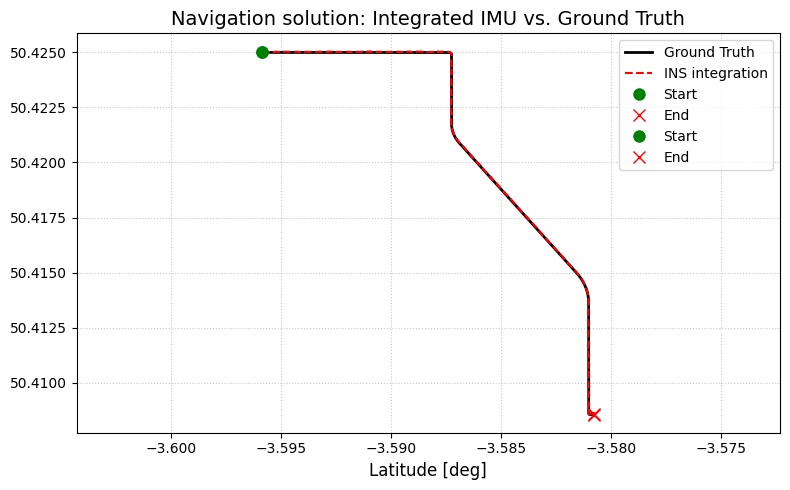

In [207]:
plt.figure(figsize=(8,5))

# Plot trajectories
plt.plot(truth['lon'], truth['lat'], 'k-', linewidth=2, label='Ground Truth')
plt.plot(nav_solution['lon'], nav_solution['lat'], 'r--', linewidth=1.5, label='INS integration')

# Highlight start and end points
plt.plot(truth['lon'].iloc[0], truth['lat'].iloc[0], 'go', markersize='8', label='Start')
plt.plot(truth['lon'].iloc[-1], truth['lat'].iloc[-1], 'rx', markersize='8', label='End')


# Highlight start and end points
plt.plot(nav_solution['lon'].iloc[0], nav_solution['lat'].iloc[0], 'go', markersize='8', label='Start')
plt.plot(nav_solution['lon'].iloc[-1], nav_solution['lat'].iloc[-1], 'rx', markersize='8', label='End')

# Formatting
plt.title('Navigation solution: Integrated IMU vs. Ground Truth', fontsize=14)
plt.xlabel('Longitude [deg]', fontsize=12)
plt.xlabel('Latitude [deg]', fontsize=12)
plt.grid(True, linestyle=':', alpha = 0.7)
plt.legend(loc='best')

# Ensure equal aspect ratio
plt.axis('equal')

plt.tight_layout()
plt.show()

In [192]:
epoch

50